# 03 Start exploring the datasets 

> Initial exploration of the data   

In [1]:
#|default_exp core.03_explore_datasets

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_5981/2594598928.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


---

In [6]:
# Load the datasets with Local Authority District demographic info 
df_lad_age_21 = pd.read_csv(const.output_path+'/LAD_age_2021.csv')
df_lad_ethn_21 = pd.read_csv(const.output_path+'/LAD_ethnicity_percent_2021.csv')
df_lad_educ_21 = pd.read_csv(const.output_path+'/LAD_education_2021.csv')

# And the ADI health dataset
df_ADI_health_21 = pd.read_csv(const.data_path+'/ADI_data/ADI_health_2021.csv')

In [7]:
df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted']].head()

,area_code,area_name,pop,DEM_afflicted
0,E07000091,New Forest,151481,1858.546949
1,E09000027,Richmond upon Thames,156795,1016.262785
2,E07000116,Tunbridge Wells,95022,876.255260
3,E07000121,Lancaster,123214,1228.376774
4,E07000042,Mid Devon,67987,547.793487


In [8]:
print(f'Number of LADs in the ADI dataset: {len(df_ADI_health_21)}. Number of LADs in the demographic dataset: {len(df_lad_age_21)}.')

Number of LADs in the ADI dataset: 309. Number of LADs in the demographic dataset: 331.


In [9]:
# Fix the mismatch in LADs resulting from the inclusion of Welsh LADs - poor old Wales :(
wales_LAD = list(df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_ADI_health_21['area_name'])]['LAD_name'])

# Drop all the LADs in Wales from datasets 
df_lad_age_21.drop(df_lad_age_21[df_lad_age_21['LAD_name'].isin(wales_LAD)].index, inplace=True)
df_lad_educ_21.drop(df_lad_educ_21[df_lad_educ_21['Area name'].isin(wales_LAD)].index, inplace=True)
df_lad_ethn_21.drop(df_lad_ethn_21[df_lad_ethn_21['Area name'].isin(wales_LAD)].index, inplace=True)

Now a little bit of processing to merge categories and get an informative percent. For covariates I'm looking at:
* percent of the population over 65
* percent of the population with A-level or higher qualifications 
* percent of the population who have white ethnicity 

In [10]:
df_lad_educ_21['ALevel_plus'] = df_lad_educ_21['level 3: a-level']+df_lad_educ_21['level 4: bsc']

Also want to look at the health conditions which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)

Could also consider:
- Depression (DEP)
- Parkinsonism - not in the QOF dataset - I suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [11]:
# merge the datasets into one 
df_dem_educ = pd.merge(df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']], df_lad_educ_21[['Area name', 'ALevel_plus']], left_on='area_name', right_on='Area name')
df_dem_educ_age = pd.merge(df_dem_educ, df_lad_age_21, left_on='area_name', right_on='LAD_name')
df_dem_covar =  pd.merge(df_dem_educ_age, df_lad_ethn_21[["Area name","White: English, Welsh, Scottish, Northern Irish or British\n(percent)"]], left_on='area_name', right_on='Area name')

# rename long col name
df_dem_covar.rename(axis=1, mapper={'White: English, Welsh, Scottish, Northern Irish or British\n(percent)':'white_pc'}, inplace=True)

In [12]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,Area name_x,ALevel_plus,LAD_name,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,Area name_y,white_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,New Forest,72749.0,New Forest,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,New Forest,93.2
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,Richmond upon Thames,112919.0,Richmond upon Thames,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,Richmond upon Thames,63.0
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,Tunbridge Wells,52395.0,Tunbridge Wells,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,Tunbridge Wells,84.2
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,Lancaster,65724.0,Lancaster,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,Lancaster,87.8
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,Mid Devon,33190.0,Mid Devon,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,Mid Devon,93.8


In [13]:
# create dataframe columns with percentages 
df_dem_covar['DEM_afflicted_pc'] = df_dem_covar['DEM_afflicted']/df_dem_covar['pop']
df_dem_covar['ALevel_plus_pc'] =  df_dem_covar['ALevel_plus']/df_dem_covar['pop']
df_dem_covar['over_65_pc'] = df_dem_covar['over_65']/df_dem_covar['pop']
df_dem_covar['female_pc'] = df_dem_covar['Female_all']/df_dem_covar['pop']

In [14]:
# and columns with disease prevalence for the comorbidities of hypertension (HYP), diabetes (DM) and stroke (STIA)
df_dem_covar['HYP_afflicted_pc'] = df_dem_covar['HYP_afflicted']/df_dem_covar['pop']
df_dem_covar['DM_afflicted_pc'] = df_dem_covar['DM_afflicted']/df_dem_covar['pop']
df_dem_covar['STIA_afflicted_pc'] = df_dem_covar['STIA_afflicted']/df_dem_covar['pop']

In [15]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,Area name_x,ALevel_plus,LAD_name,...,over_65,Area name_y,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,New Forest,72749.0,New Forest,...,51920.6826,New Forest,93.2,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,Richmond upon Thames,112919.0,Richmond upon Thames,...,31637.7606,Richmond upon Thames,63.0,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,Tunbridge Wells,52395.0,Tunbridge Wells,...,22570.0090,Tunbridge Wells,84.2,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,Lancaster,65724.0,Lancaster,...,29465.7648,Lancaster,87.8,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,Mid Devon,33190.0,Mid Devon,...,20046.6806,Mid Devon,93.8,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507


Text(0, 0.5, '% population dementia')

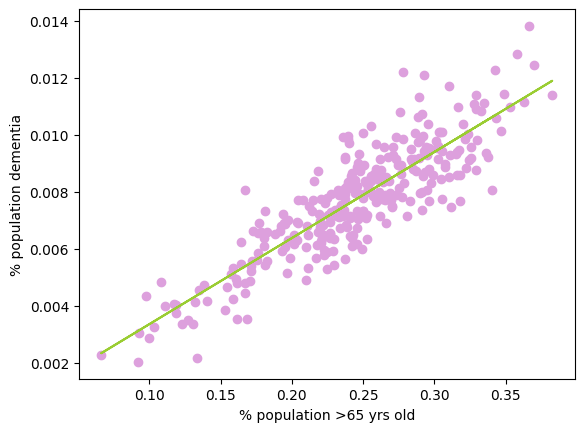

In [16]:
# label data for regression
x_age = df_dem_covar['over_65_pc'].values.reshape(-1,1)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression
regr.fit(x_age, y)
y_pred_age = regr.predict(x_age)

# plot 
plt.scatter(x_age, y, color='plum')
plt.plot(x_age, y_pred_age, color='yellowgreen')
plt.xlabel('% population >65 yrs old')
plt.ylabel('% population dementia')

Text(0, 0.5, '% population dementia')

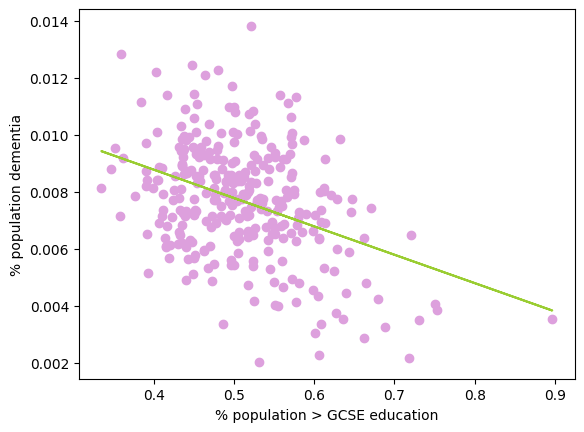

In [17]:
# label data for regression
x_educ = df_dem_covar['ALevel_plus_pc'].values.reshape(-1,1)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression
regr.fit(x_educ, y)
y_pred_educ = regr.predict(x_educ)

# plot 
plt.scatter(x_educ, y, color='plum')
plt.plot(x_educ, y_pred_educ, color='yellowgreen')
plt.xlabel('% population > GCSE education') # i.e. individuals with A-levels or above 
plt.ylabel('% population dementia')

Can look at the residuals. The residual is the difference between an observed value, and the value predicted by the linear regression model.

Text(0.5, 0, '% population > GCSE education')

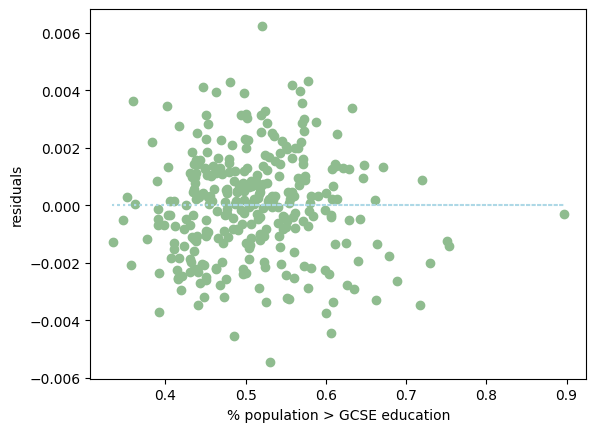

In [18]:
# look at the residuals 
resid_educ = y-y_pred_educ
plt.scatter(x_educ, resid_educ, color='darkseagreen')
plt.plot(x_educ, np.zeros(len(x_educ)), ':', color='lightblue')
plt.ylabel('residuals')
plt.xlabel('% population > GCSE education')

In [19]:
df_dem_covar[df_dem_covar['ALevel_plus_pc']>0.8]

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,Area name_x,ALevel_plus,LAD_name,...,over_65,Area name_y,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
205,E07000008,Cambridge,102992,364.254325,7409.568495,3016.509292,938.635064,Cambridge,92352.0,Cambridge,...,16675.8981,Cambridge,53.0,0.003537,0.896691,0.161914,0.694687,0.071943,0.029289,0.009114


Text(0, 0.5, '% population dementia')

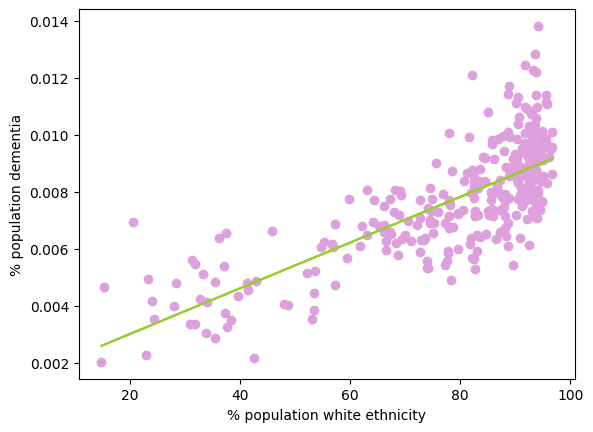

In [20]:
# label data for regression
x_ethn = df_dem_covar['white_pc'].values.reshape(-1,1)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression
regr.fit(x_ethn, y)
y_pred_ethn = regr.predict(x_ethn)

# plot 
plt.scatter(x_ethn, y, color='plum')
plt.plot(x_ethn, y_pred_ethn, color='yellowgreen')
plt.xlabel('% population white ethnicity')
plt.ylabel('% population dementia')

Text(0, 0.5, '% population dementia')

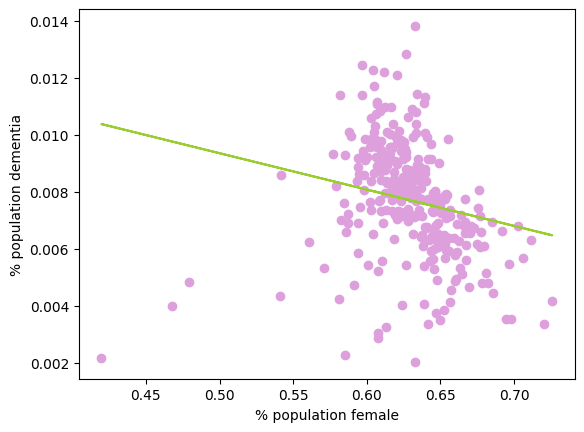

In [21]:
# label data for regression
x_gend = df_dem_covar['female_pc'].values.reshape(-1,1)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression
regr.fit(x_gend, y)
y_pred_gend = regr.predict(x_gend)

# plot 
plt.scatter(x_gend, y, color='plum')
plt.plot(x_gend, y_pred_gend, color='yellowgreen')
plt.xlabel('% population female')
plt.ylabel('% population dementia')

Now going to look at the health problems which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)
- Depression (DEP)

- Parkinsonism - not in the QOF dataset - suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [22]:
df_dem_covar.columns

Index(['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted',
       'DM_afflicted', 'STIA_afflicted', 'Area name_x', 'ALevel_plus',
       'LAD_name', 'Female_all', 'Male_all', 'all_age', 'Female_over_65',
       'Male_over_65', 'over_65', 'Area name_y', 'white_pc',
       'DEM_afflicted_pc', 'ALevel_plus_pc', 'over_65_pc', 'female_pc',
       'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'],
      dtype='object')

In [23]:
# label data for regression
x_hyp = df_dem_covar['HYP_afflicted_pc'].values.reshape(-1,1)
x_dm = df_dem_covar['DM_afflicted_pc'].values.reshape(-1,1)
x_stia = df_dem_covar['STIA_afflicted_pc'].values.reshape(-1,1)

y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities

# hypertension
regr.fit(x_hyp, y)
y_pred_hyp = regr.predict(x_hyp)

# diabetes 
regr.fit(x_dm, y)
y_pred_dm = regr.predict(x_dm)

# stroke (STIA)
regr.fit(x_stia, y)
y_pred_stia = regr.predict(x_stia)

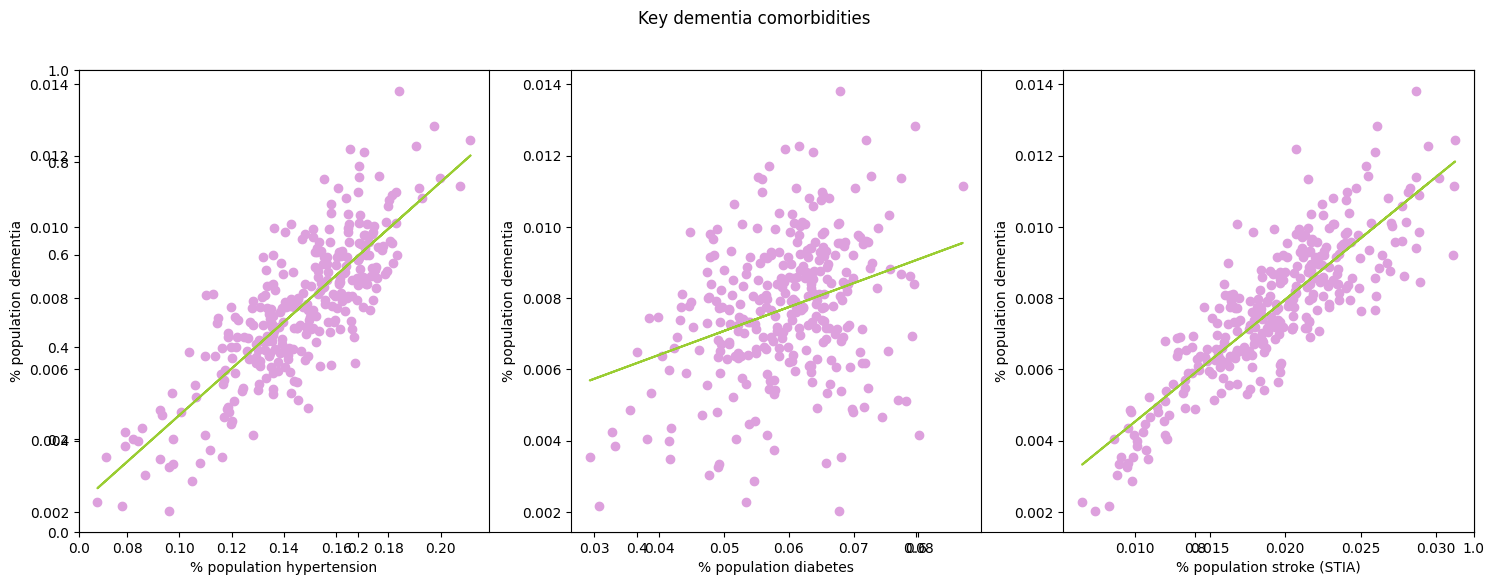

In [24]:
# plot linear regrssion for each comorbiditiy

plt.subplots(figsize=(18,6))

plt.subplot(1, 3, 1)
plt.scatter(x_hyp, y, color='plum')
plt.plot(x_hyp, y_pred_hyp, color='yellowgreen')
plt.xlabel('% population hypertension')
plt.ylabel('% population dementia')

plt.subplot(1, 3, 2)
plt.scatter(x_dm, y, color='plum')
plt.plot(x_dm, y_pred_dm, color='yellowgreen')
plt.xlabel('% population diabetes')
plt.ylabel('% population dementia')

plt.subplot(1, 3, 3)
plt.scatter(x_stia, y, color='plum')
plt.plot(x_stia, y_pred_stia, color='yellowgreen')
plt.xlabel('% population stroke (STIA)')
plt.ylabel('% population dementia')

plt.suptitle('Key dementia comorbidities')
plt.show()

When there's multiple variables it's good practise to check for colinearity between them. For this use statsmodels to calculate the variance inflation factor (VIF).

**NOTE** `statsmodels` has the standard parameter that b=0, in y=mx+b so it assumes all linear regressions pass through the origin. You need to add a constant using `add_constant` to fix this. 

In [25]:
# variables 
x_comor_covar = df_dem_covar[['HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']]

# VIF datafram 
comor_vif_data = pd.DataFrame()
comor_vif_data["comor_feature"] = x_comor_covar.columns

# calculate VIF for each factor 
x_comor_covar_const = add_constant(x_comor_covar)
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]


pd.Series([variance_inflation_factor(x_comor_covar_const.values, i)
                          for i in range(x_comor_covar_const.shape[1])],
                          index=x_comor_covar_const.columns)

const              4.105162
HYP_afflicted     65.502495
DM_afflicted      19.785930
STIA_afflicted    23.285511
dtype: float64

So, perhaps as expected, there is high collinearity between the common dementia comorbidities.

In [26]:
# Multiple linear regression using statsmodels (and formula)

# x_all_covar_const - this is the variables of interest
x_comor_covar = df_dem_covar[['HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']]
x_comor_covar_const = add_constant(x_comor_covar)

y = df_dem_covar['DEM_afflicted_pc']


model = ols(formula = f"y ~ HYP_afflicted + DM_afflicted + STIA_afflicted", data=x_comor_covar).fit()
y_pred_comor = model.predict(exog=x_comor_covar)

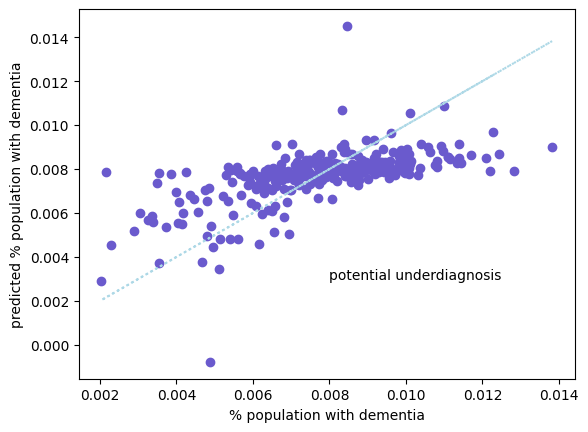

In [27]:
# look at the residuals 
plt.plot(y, y, ':', color='lightblue')
plt.scatter(y, y_pred_comor, color='slateblue')
# just visualising this against educ for sake of an x-axis (these y values are the result of multiple linear regression)
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.text(0.008, 0.003, r'potential underdiagnosis', fontsize=10)
plt.show()

This figure above is interesting, as it suggests that maybe accounting for comorbidities is really good at 'flattening' out the predicted % of the population with dementia 

In [28]:
# variables 
x_all_covar = df_dem_covar[['ALevel_plus_pc', 'white_pc', 'over_65_pc', 'female_pc']]

# VIF datafram 
vif_data = pd.DataFrame()
vif_data["feature"] = x_all_covar.columns

# calculate VIF for each factor 
x_all_covar_const = add_constant(x_all_covar)
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]


pd.Series([variance_inflation_factor(x_all_covar_const.values, i)
                          for i in range(x_all_covar_const.shape[1])],
                          index=x_all_covar_const.columns)

const             579.582663
ALevel_plus_pc      1.229168
white_pc            3.558832
over_65_pc          3.279382
female_pc           1.084889
dtype: float64

The multicollinearity looks fine, so now can do the linear regression.

In [29]:
# Multiple linear regression using statsmodels (and formula)

# x_all_covar_const - this is the variables of interest
x_all_covar = df_dem_covar[['ALevel_plus_pc', 'white_pc', 'over_65_pc', 'female_pc']]
x_all_covar_const = add_constant(x_all_covar)

y = df_dem_covar['DEM_afflicted_pc']


model = ols(formula = f"y ~ ALevel_plus_pc + white_pc + over_65_pc + female_pc", data=x_all_covar).fit()
y_pred_new = model.predict(exog=x_all_covar)

In [30]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     244.3
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           3.47e-93
Time:                        17:08:08   Log-Likelihood:                 1689.8
No. Observations:                 306   AIC:                            -3370.
Df Residuals:                     301   BIC:                            -3351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0036      0.001      2.

In [31]:
df_ADI_health_21

,area_code,area_name,pop,AF_prevalence_rate,AF_afflicted,AST_prevalence_rate,AST_afflicted,CAN_prevalence_rate,CAN_afflicted,CHD_prevalence_rate,...,OST_prevalence_rate,OST_afflicted,PAD_prevalence_rate,PAD_afflicted,PC_prevalence_rate,PC_afflicted,RA_prevalence_rate,RA_afflicted,STIA_prevalence_rate,STIA_afflicted
0,E07000091,New Forest,151481,0.037984,5753.859888,0.069657,10551.669087,0.056861,8613.329996,0.043426,...,0.010598,1605.434527,0.007379,1117.747541,0.005141,778.690641,0.008604,1303.321984,0.029487,4466.648271
1,E09000027,Richmond upon Thames,156795,0.017120,2684.368432,0.046018,7215.449375,0.033366,5231.607558,0.020417,...,0.002118,332.099783,0.002960,464.064892,0.003104,486.640518,0.004424,693.725530,0.012880,2019.443594
2,E07000116,Tunbridge Wells,95022,0.025498,2422.835479,0.058405,5549.739971,0.041248,3919.496364,0.024687,...,0.005725,544.016401,0.004763,452.599475,0.007897,750.367017,0.006496,617.288909,0.019880,1889.024705
3,E07000121,Lancaster,123214,0.023064,2841.841575,0.066656,8212.999780,0.035019,4314.836296,0.035053,...,0.001550,191.000646,0.009448,1164.096505,0.007763,956.571200,0.007060,869.944795,0.021488,2647.583108
4,E07000042,Mid Devon,67987,0.028983,1970.435397,0.070642,4802.730858,0.041270,2805.842744,0.036107,...,0.002711,184.300738,0.005785,393.327162,0.003479,236.550190,0.006567,446.446170,0.022507,1530.207441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,E07000098,Hertsmere,82921,0.019494,1616.491835,0.052616,4362.976295,0.035622,2953.797695,0.028049,...,0.003354,278.104929,0.004172,345.922307,0.003834,317.907960,0.005421,449.540010,0.016021,1328.437922
305,E08000024,Sunderland,228781,0.026137,5979.644544,0.065091,14891.513255,0.037762,8639.243950,0.045656,...,0.003288,752.241689,0.009145,2092.301367,0.005659,1294.665064,0.007087,1621.337353,0.023566,5391.466952
306,E06000050,Cheshire West and Chester,281913,0.027113,7643.558412,0.067960,19158.715422,0.040867,11521.066000,0.034881,...,0.004449,1254.140095,0.007416,2090.627425,0.003657,1030.998721,0.009195,2592.189306,0.020497,5778.511168
307,E07000210,Mole Valley,72165,0.028208,2035.649632,0.060445,4362.026715,0.045425,3278.096404,0.030086,...,0.002551,184.081277,0.005175,373.481896,0.002676,193.115625,0.006323,456.328233,0.020728,1495.801962


In [32]:
lm_residuals = y-y_pred_new

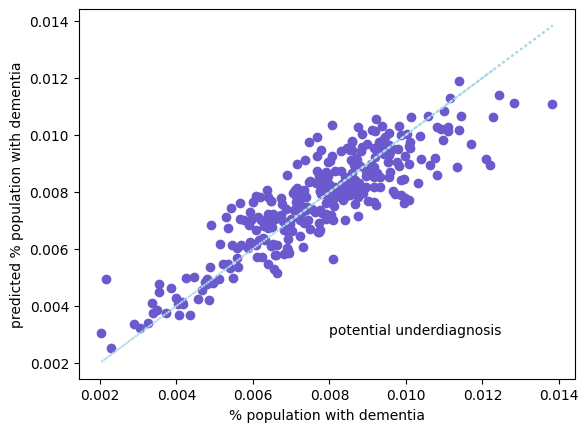

In [33]:
# look at the residuals 
plt.plot(y, y, ':', color='lightblue')
plt.scatter(y, y_pred_new, color='slateblue')
# just visualising this against educ for sake of an x-axis (these y values are the result of multiple linear regression)
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.text(0.008, 0.003, r'potential underdiagnosis', fontsize=10)
plt.show()

In [34]:
df_dem_covar[lm_residuals<-0.001]

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,Area name_x,ALevel_plus,LAD_name,...,over_65,Area name_y,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,Mid Devon,33190.0,Mid Devon,...,20046.6806,Mid Devon,93.8,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507
6,E06000020,Telford and Wrekin,143769,853.017319,20443.569204,9116.020380,2828.439857,Telford and Wrekin,66568.0,Telford and Wrekin,...,32962.0157,Telford and Wrekin,83.0,0.005933,0.463021,0.229271,0.655991,0.142197,0.063407,0.019674
8,E07000124,Ribble Valley,51607,410.559025,8664.860488,2858.159002,1111.942436,Ribble Valley,29319.0,Ribble Valley,...,14966.4450,Ribble Valley,94.1,0.007955,0.568121,0.290008,0.612514,0.167901,0.055383,0.021546
16,E07000189,South Somerset,139203,1194.625778,23717.795428,8533.219891,3133.054788,South Somerset,68474.0,South Somerset,...,44244.8780,South Somerset,91.7,0.008582,0.491900,0.317844,0.634984,0.170383,0.061301,0.022507
37,E06000035,Medway,220365,1083.120308,32850.228353,14176.271443,2943.802796,Medway,97010.0,Medway,...,46329.2788,Medway,78.3,0.004915,0.440224,0.210239,0.647441,0.149072,0.064331,0.013359
40,E07000044,South Hams,74072,597.624370,12201.179619,4036.440908,1928.689732,South Hams,42560.0,South Hams,...,25235.8819,South Hams,94.2,0.008068,0.574576,0.340694,0.623954,0.164721,0.054493,0.026038
55,E06000053,Isles of Scilly,1909,14.246269,231.897595,75.980100,36.407131,Isles of Scilly,996.0,Isles of Scilly,...,594.7725,Isles of Scilly,93.7,0.007463,0.521739,0.311562,0.595380,0.121476,0.039801,0.019071
60,E07000237,Worcester,81888,433.843276,11128.833269,4726.643966,1428.763978,Worcester,44575.0,Worcester,...,18404.3859,Worcester,82.7,0.005298,0.544341,0.224751,0.645879,0.135903,0.057721,0.017448
68,E07000113,Swale,120107,731.262224,18488.326080,7579.869438,1950.246904,Swale,49938.0,Swale,...,29107.6730,Swale,88.6,0.006088,0.415779,0.242348,0.637954,0.153932,0.063109,0.016238
72,E07000227,Horsham,119117,914.990506,17800.925913,6043.030819,2306.578104,Horsham,66492.0,Horsham,...,33688.3335,Horsham,88.1,0.007681,0.558207,0.282817,0.633585,0.149441,0.050732,0.019364
